### Bank Data Analysis - Financial Ratios

### Input source data - US Banks Financial Quarterly Ratios 2001-2023
### Source data URL - https://www.kaggle.com/datasets/neutrino404/all-us-banks-financial-quarterly-ratios-2001-2023

In [1]:
## Python Libraries referenced

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
## Create dataframe from downloaded .csv file

df = pd.read_csv('data/total_bank_data.csv')

In [5]:
## Identify df columns with at least one NaN value

columns_with_nan = df.columns[df.isna().any()].tolist()
print(f"Columns with at least one NaN value: {columns_with_nan}")

Columns with at least one NaN value: ['CBLRIND', 'CBLRINDQ', 'DDTR', 'ELNATQR', 'ELNLOSQ', 'NTRIPCR', 'NTRR', 'NTTOTQ', 'ROE', 'TRNIPCOCR', 'TRNR', 'TSR', 'EEFF', 'EEFFQ', 'EEFFQR', 'IEFF', 'IEFFQ', 'NTCONQR', 'NTRSMMDAR', 'NTRSOTHR', 'RBCT1CER', 'ROAPTXQ', 'ROAQ', 'ROEQ', 'RWAJ', 'STNAME']


In [7]:
## drop columsn_with_nan and create df_cl (cleaned version of df)
## No row is dropped as it will result in loss of banks as each row corrseponds to a bank

df_cl = df.drop(columns_with_nan, axis = 1)
print(df.shape)
print(df_cl.shape)

(656438, 796)
(656438, 770)


In [9]:
## Select QUARTER ending with 2023-06-30
## The df_20230630 will be used to perform the PCA and K-Means Clustering

df_20230630_all = df_cl.query("REPDTE == 20230630")
print(df_20230630_all.shape)

(4714, 770)


In [13]:
## Read list of CERTs of Banks with Assets >= $10,000,000,000 on 2023/06/30 from file downlaoded from FDIC.gov
cert_df_20230630 = pd.read_csv("data/CERT_List_20230630.csv")

In [17]:
## Select Bank data using cert_df_20230630
## A Large bank has Total Assets >= $150 B 

#ovie_ratings_df = pd.merge(ratings_df, movies_df, on="movieId", how="inner")
df_20230630 = pd.merge(df_20230630_all, cert_df_20230630, on="CERT", how="inner")

print(df_20230630.shape)

(158, 770)


In [19]:
column_list = df_20230630.columns.tolist()
print(column_list)

['ABCUBKR', 'ABCUOTHR', 'ABCXBKR', 'ABCXOTHR', 'ADDNONINTEXPQR', 'ADDNONINTEXPR', 'ALLOTHLR', 'ASCEOTHR', 'ASCERESR', 'ASDROTHR', 'ASDRRESR', 'ASSTLTR', 'AVASSETJR', 'BKPREMR', 'BROINSR', 'BROR', 'CD1T3R', 'CD1T3SR', 'CD3LESR', 'CD3LESSR', 'CD3T12R', 'CD3T12SR', 'CDOV3R', 'CDOV3SR', 'CERT', 'CHBALIR', 'CHBALNIR', 'CHBALR', 'CHCICR', 'CHCOINR', 'CHFRBR', 'CHITEMR', 'CHUSR', 'COREDEPR', 'CRAGQR', 'CRAGR', 'CRAGSMQR', 'CRAGSMR', 'CRAUTOQR', 'CRAUTOR', 'CRCINUSQR', 'CRCINUSR', 'CRCIQR', 'CRCIR', 'CRCONOTHR', 'CRCONOTQR', 'CRCONQR', 'CRCONR', 'CRCRCDQR', 'CRCRCDR', 'CRDEPNUQR', 'CRDEPNUSR', 'CRDEPQR', 'CRDEPR', 'CRFORGVQR', 'CRFORGVR', 'CRLNLSQR', 'CRLNLSR', 'CRLSQR', 'CRLSR', 'DEPDOMR', 'DEPFORR', 'DEPIFORR', 'DEPIPCCFR', 'DEPNIFORR', 'DEPR', 'DRLNLSQR', 'DRLNLSR', 'EAMINTANR', 'EAMINTQR', 'EDEPDOMQR', 'EDEPDOMR', 'EDEPFORQR', 'EDEPFORR', 'EFREPPQR', 'EFREPPR', 'EINTEXPR', 'EINTXQR', 'ELNATRR', 'EOTHNINQR', 'EOTHNINTR', 'EPREMAGGR', 'EPREMAGQR', 'EQCDIVCR', 'EQCDIVPR', 'EQCDIVQR', 'EQCDIVR

#### DROP Columns 'CERT', 'REPDTE', 'REPYEAR' as they can be a source of noise for the financial ratio data
#### The CERT ids are available in cert_df_20230630 which has the same index values as the resulting dataframe
#### after dropping the three columns

In [21]:
df_20230630_sel = df_20230630.drop(['CERT', 'REPDTE', 'REPYEAR'], axis = 1)
print(df_20230630_sel.shape)

(158, 767)


#### DROP Non-Numeric Columns

In [23]:
non_num_columns = df_20230630_sel.select_dtypes(exclude='number').columns.tolist()
print(non_num_columns)

df_20230630_num = df_20230630_sel.drop(non_num_columns, axis = 1)
print(df_20230630_num.shape)

['NAME']
(158, 766)


In [25]:
df_non_num = df_20230630_sel[non_num_columns]
print(df_non_num.head())

                           NAME
0         FIRST INTERSTATE BANK
1  FIRST-CITIZENS BANK&TRUST CO
2                      BANK OZK
3               CENTENNIAL BANK
4                  CADENCE BANK


#### Normalize the financial ratio columns
#### by subtrating the mean and then dividing by the standard deviation

In [28]:
mu = df_20230630_num.mean()
sigma = df_20230630_num.std()
df_norm = (df_20230630_num - mu) / sigma
print(df_norm.shape)
df_norm.describe()


(158, 766)


,ABCUBKR,ABCUOTHR,ABCXBKR,ABCXOTHR,ADDNONINTEXPQR,ADDNONINTEXPR,ALLOTHLR,ASCEOTHR,ASCERESR,ASDROTHR,...,UCCOMRESR,UCCOMREUR,UCCRCDR,UCLOCR,UCOTHERR,UCOVER1R,UCR,UCSCR,UNINCFORR,VOLIABR
count,1.580000e+02,1.580000e+02,158.000000,1.580000e+02,1.580000e+02,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,1.580000e+02,...,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,0.0,1.580000e+02,1.580000e+02,1.580000e+02,1.580000e+02,1.580000e+02
mean,2.248553e-17,5.621382e-18,0.000000,5.621382e-18,2.670157e-17,-1.039956e-16,1.124276e-17,2.951226e-17,0.000000,-2.670157e-17,...,-1.855056e-16,1.124276e-17,3.372829e-17,0.000000,NaN,4.216037e-17,8.994212e-17,5.621382e-17,-2.178286e-17,1.236704e-16
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.124226e-01,-7.955573e-02,-0.112182,-7.955573e-02,-6.469843e-01,-6.476791e-01,-4.144864e-01,-1.898588e-01,-0.151896,-1.939088e-01,...,-8.525414e-01,-4.613577e-01,-2.322922e-01,-0.785437,NaN,-1.299397e+00,-5.819969e-01,-7.955573e-02,-1.209117e-01,-1.145111e+00
25%,-1.124226e-01,-7.955573e-02,-0.112182,-7.955573e-02,-3.074680e-01,-3.151613e-01,-2.623664e-01,-1.898588e-01,-0.151896,-1.939088e-01,...,-6.585196e-01,-4.613577e-01,-2.322922e-01,-0.737779,NaN,-6.073321e-01,-3.293353e-01,-7.955573e-02,-1.209117e-01,-6.291931e-01
50%,-1.124226e-01,-7.955573e-02,-0.112182,-7.955573e-02,-2.260726e-01,-2.197978e-01,-1.611678e-01,-1.898588e-01,-0.151896,-1.939088e-01,...,-1.113605e-01,-4.531139e-01,-2.306601e-01,-0.243927,NaN,-5.770492e-02,-2.095090e-01,-7.955573e-02,-1.209117e-01,-2.091873e-01
75%,-1.124226e-01,-7.955573e-02,-0.112182,-7.955573e-02,-8.307229e-02,-1.003618e-01,-4.405037e-02,-1.898588e-01,-0.134061,-1.939088e-01,...,3.291406e-01,1.353835e-02,-1.948302e-01,0.473075,NaN,4.366597e-01,-3.584861e-02,-7.955573e-02,-1.209117e-01,3.550621e-01
max,9.556040e+00,1.249025e+01,9.726417,1.249025e+01,8.682608e+00,8.568043e+00,1.032841e+01,9.653063e+00,11.899645,9.372171e+00,...,9.094529e+00,5.124254e+00,7.721899e+00,8.310314,NaN,5.893855e+00,7.671607e+00,1.249025e+01,9.499655e+00,6.133293e+00


#### The Normaization process can create NaN values when the Standard Deviation is 0 thus resulting in division by 0
#### List and DROP all such columns with NaN values created as a result of the Normalization process

In [31]:
## check for NaN columns in norm
columns_with_nan1 = df_norm.columns[df_norm.isna().any()].tolist()
print(columns_with_nan1)

## DROP NaN columns from norm (NaN possibly due to division by zero)

df_norm_cl = df_norm.drop(columns_with_nan1, axis = 1)
print(df_norm_cl.shape)

['CRDEPNUQR', 'CRDEPNUSR', 'CRDEPQR', 'CRDEPR', 'CRFORGVQR', 'CRFORGVR', 'LIABEQR', 'SCASPNSUMR', 'DEPCSBQR', 'DRDEPNUQR', 'DRDEPNUSR', 'DRDEPQR', 'DRDEPR', 'DRFORGVQR', 'DRFORGVR', 'EQCTRSTXR', 'LAGR', 'LCIR', 'LCONR', 'LOREGTYR', 'LSAOAR', 'LSAORER', 'LSASCDBTR', 'NALAGR', 'NALCIR', 'NALCONR', 'NALREAGR', 'NTDEPNUQR', 'NTDEPNUSQ', 'NTDEPNUSR', 'NTDEPQR', 'NTDEPR', 'NTFORGVQR', 'NTFORGVR', 'OREINVR', 'P3FGR', 'P3LAGR', 'P3LCIR', 'P3LCONR', 'P3LREAGR', 'P3LTOTR', 'ASSETR', 'AVMMLFR', 'AVPPPPLGR', 'ESTINSR', 'MMLFBALR', 'P9FGR', 'P9LAGR', 'P9LCIR', 'P9LCONR', 'P9LREAGR', 'P9LRECONR', 'P9LREMULR', 'P9LRENRSR', 'P9LRERESR', 'PARTCONVR', 'PPPLF1LSR', 'PPPLFOV1R', 'PPPLNPLGR', 'SZ30CIR', 'SZ90CIR', 'SZCRCIR', 'SZCRCRCDR', 'SZDRCIR', 'SZISLCCDR', 'SZISLCONR', 'UCOTHERR']
(158, 699)


#### The dataframe df_norm_cl is used for the Bank Data analysis

#### STEP 1 - Paerform Principal Component Analysis (PCA)
#### Perform Singular Value Decomposition (SVD)

In [35]:
## PERFORM SINGULAR VALUE DECOMPOSITION (SVD)

from scipy.linalg import svd
U, s, Vt = svd(df_norm_cl, full_matrices=True)
Sigma = np.diag(s)
V = Vt.T

#### Convert matrices U, Sigma and V to DataFrames

In [38]:
print(df_norm_cl.shape)

U_df = pd.DataFrame(U)
print(U_df.shape)

Sigma_df = pd.DataFrame(Sigma)
print(Sigma_df.shape)

V_df = pd.DataFrame(V)
print(V_df.shape)

(158, 699)
(158, 158)
(158, 158)
(699, 699)


#### Plot Sigma vs Column Index (representing the descending order of signifcance)

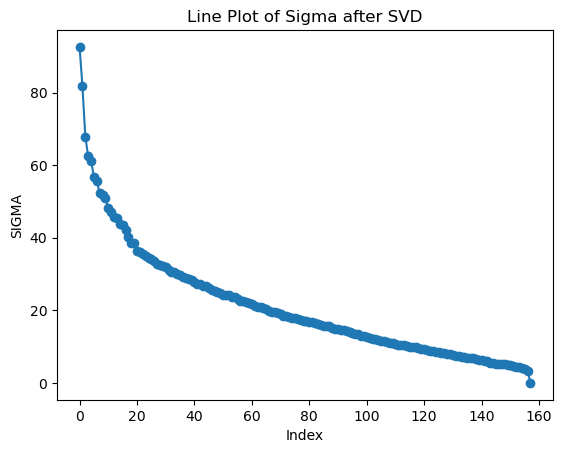

In [41]:
plt.plot(s, marker='o')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('SIGMA')
plt.title('Line Plot of Sigma after SVD')

plt.show()

In [43]:
!pip install kneed

In [45]:
from kneed import KneeLocator

sigma_values = np.diag(Sigma)

# Create the scree plot
x = np.arange(1, len(sigma_values) + 1)
y = sigma_values

# Locate the elbow point
knee = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_point = knee.knee

print("Elbow point index:", elbow_point)


Elbow point index: 28


#### As Elbow point index is 28, r is set to 29

In [48]:
## Significant Principal Components is r = elbow_point + 1 = 29

r = elbow_point + 1

Ur = U[:, :r]
Sigmar = Sigma[:r, :r]

df_norm_rr = pd.DataFrame(Ur @ Sigmar)


In [50]:
print(df_norm_rr)

           0          1          2         3          4         5          6   \
0   -5.766177   7.825182  -5.552352  2.899130  -7.681434  2.100025  -8.745387   
1    8.505143  -2.795335 -27.710844  8.067775  47.013145  4.729831 -12.121056   
2    0.426979   5.998029  -2.920067 -4.824631   0.124712  3.342367  -1.868639   
3   -2.426866   6.177943  -4.694891  3.183564  -2.708921  1.653779   0.254936   
4   -3.604884   5.262896  -3.068288  1.276755  -2.387350  0.660096   0.331045   
..        ...        ...        ...       ...        ...       ...        ...   
153 -1.699570 -18.339080  -1.305560  1.271571  -5.040235  6.319922  -1.137069   
154 -1.406978   4.133601   0.811674 -4.362749   0.163307  2.112702  -1.734999   
155 -0.625686   3.920275  -1.226330  0.627130   0.362868  0.718857   0.501788   
156 -1.472066  -3.732247  -2.151332 -0.497919   0.154522  0.381179  -1.131550   
157 -0.259377   0.318855  -0.850887 -1.188217   0.100197 -2.646507  -0.092045   

           7          8    

#### STEP 2 - Perform K-Means Clustering

In [53]:
import sklearn.cluster as cluster

#### SET Number of clusters = 4

In [56]:
kmeans = cluster.KMeans(n_clusters=4, init='random')
kmeans.fit(df_norm_rr)

kmeans.labels_

C:\Users\PravinPowale\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 2, 0, 3, 2, 3, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       0, 1, 1, 2, 2, 0, 0, 0, 2, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2,
       2, 2, 2, 2, 3, 0, 3, 2, 1, 0, 0, 3, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2,
       1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 1,
       0, 0, 2, 0])

In [58]:
df_norm_rr_all = pd.concat([df_non_num['NAME'].reset_index(), df_20230630['CERT'].reset_index(), df_norm_rr], axis=1, ignore_index = True)
#print(df_norm_rr_all)
klabels_df = pd.DataFrame(kmeans.labels_)
print(klabels_df.shape)
bank_cluster_df = pd.concat([klabels_df.reset_index(), df_norm_rr_all], axis=1, ignore_index = True)

(158, 1)


In [60]:
print(bank_cluster_df.head())

   0   1   2                             3   4      5         6         7   \
0   0   0   0         FIRST INTERSTATE BANK   0   1105 -5.766177  7.825182   
1   1   3   1  FIRST-CITIZENS BANK&TRUST CO   1  11063  8.505143 -2.795335   
2   2   0   2                      BANK OZK   2    110  0.426979  5.998029   
3   3   0   3               CENTENNIAL BANK   3  11241 -2.426866  6.177943   
4   4   0   4                  CADENCE BANK   4  11813 -3.604884  5.262896   

          8         9   ...        25        26        27        28        29  \
0  -5.552352  2.899130  ...  0.300200  0.025842  7.654085  4.844224 -0.540589   
1 -27.710844  8.067775  ... -0.753906  0.405898 -0.627333 -2.115602 -0.764823   
2  -2.920067 -4.824631  ...  4.144984  2.105755  1.898627  3.984436 -3.570558   
3  -4.694891  3.183564  ...  1.015517 -0.497285 -0.809833  1.133209 -0.461913   
4  -3.068288  1.276755  ... -0.667819 -1.449723 -0.122941 -2.708944 -2.452923   

         30        31        32        33   

In [62]:
bank_label_df = bank_cluster_df.iloc[:, [1, 3, 5]]

bank_label_df.columns = ['label', 'bankname', 'CERT']

# Print the new DataFrame
print(bank_label_df)

     label                      bankname   CERT
0        0         FIRST INTERSTATE BANK   1105
1        3  FIRST-CITIZENS BANK&TRUST CO  11063
2        0                      BANK OZK    110
3        0               CENTENNIAL BANK  11241
4        0                  CADENCE BANK  11813
..     ...                           ...    ...
153      1             NORTHERN TRUST CO    913
154      0          VALLEY NATIONAL BANK   9396
155      0             ROCKLAND TRUST CO   9712
156      2                 COMERICA BANK    983
157      0                   TRUIST BANK   9846

[158 rows x 3 columns]


#### Select Label 0 (Cluster #0) banks

In [65]:
label_0_df = bank_label_df.query("label == 0")
print(label_0_df)

     label               bankname   CERT
0        0  FIRST INTERSTATE BANK   1105
2        0               BANK OZK    110
3        0        CENTENNIAL BANK  11241
4        0           CADENCE BANK  11813
5        0         PROVIDENT BANK  12010
..     ...                    ...    ...
151      0            ARVEST BANK   8728
152      0           SYNOVUS BANK    873
154      0   VALLEY NATIONAL BANK   9396
155      0      ROCKLAND TRUST CO   9712
157      0            TRUIST BANK   9846

[85 rows x 3 columns]


#### Select Label 1 (Cluster #1) banks

In [68]:
label_1_df = bank_label_df.query("label == 1")
print(label_1_df)

     label                     bankname   CERT
15       1   STATE STREET BANK&TRUST CO     14
72       1       GOLDMAN SACHS BANK USA  33124
89       1           BANK OF AMERICA NA   3510
90       1          WELLS FARGO BANK NA   3511
118      1  HSBC BANK USA NATIONAL ASSN  57890
132      1       JPMORGAN CHASE BANK NA    628
134      1      BANK OF NEW YORK MELLON    639
141      1       CITIBANK NATIONAL ASSN   7213
153      1            NORTHERN TRUST CO    913


#### Select Label 2 (Cluster #2) banks

In [71]:
label_2_df = bank_label_df.query("label == 2")
print(label_2_df)

     label                      bankname   CERT
6        2  FARMERS&MERCHANTS BK LONG BE   1225
17       2        APPLE BANK FOR SAVINGS  16068
23       2            CITY NATIONAL BANK  17281
25       2         KEYBANK NATIONAL ASSN  17534
28       2           FIRST HAWAIIAN BANK  17985
29       2                BANK OF HAWAII  18053
31       2         TD BANK NATIONAL ASSN  18409
32       2                   CATHAY BANK  18503
33       2                     FIRSTBANK  18714
36       2    ISRAEL DISCOUNT BANK OF NY  19977
37       2            CITY NB OF FLORIDA  20234
44       2                 COMMERCE BANK  24998
45       2         BANK OF AMERICA CA NA  25178
47       2       SOFI BANK NATIONAL ASSN  26881
50       2           WELLS FARGO NB WEST  27389
53       2  CAPITOL FEDERAL SAVINGS BANK  27981
54       2       WASHINGTON FEDERAL BANK  28088
58       2                       NEXBANK  29209
60       2      THIRD FS&LA OF CLEVELAND  30012
65       2                EAST WEST BANK

#### Select Label 3 (Cluster #3) banks

In [74]:
label_3_df = bank_label_df.query("label == 3")
print(label_3_df)

     label                      bankname   CERT
1        3  FIRST-CITIZENS BANK&TRUST CO  11063
49       3                SYNCHRONY BANK  27314
51       3           AMERICAN EXPRESS NB  27471
99       3     CAPITAL ONE NATIONAL ASSN   4297
107      3                 DISCOVER BANK   5649
108      3        BARCLAYS BANK DELAWARE  57203
114      3         COMENITY CAPITAL BANK  57570
116      3                     ALLY BANK  57803
121      3               SALLIE MAE BANK  58177


In [76]:
failed_banks_df = pd.read_csv("data/failed-banks-data.csv")
print(failed_banks_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Bank Name               571 non-null    object
 1   City                    571 non-null    object
 2   State                   571 non-null    object
 3   CERT                    571 non-null    int64 
 4   Acquiring Institution   571 non-null    object
 5   Closing Date            571 non-null    object
 6   Fund                    571 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 31.4+ KB
None


In [78]:
check_df = pd.merge(bank_label_df, failed_banks_df, on="CERT", how="inner")
print(check_df.shape)

(0, 9)


#### Since the number of rows of the inner join is 0, none of the failed banks are present in the set of banks selected
#### Thus cluster numbers 0, 1, 2, and 3 do not correspond to any of the failed banks

In [68]:
bank_label_df.to_csv('data/label_data_4_clusters.csv', index=False)

In [81]:
print(bank_label_df.head())

   label                      bankname   CERT
0      0         FIRST INTERSTATE BANK   1105
1      3  FIRST-CITIZENS BANK&TRUST CO  11063
2      0                      BANK OZK    110
3      0               CENTENNIAL BANK  11241
4      0                  CADENCE BANK  11813


In [83]:
print(bank_label_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     158 non-null    int32 
 1   bankname  158 non-null    object
 2   CERT      158 non-null    int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.2+ KB
None


#### Create Logistic Regression Model based upon the labeled data created by clustering (n_clusters = 4)

#### set X as concatenation of df_norm_cl (all numeric ratios after cleaning and normalization steps
#### set y = label column from bank_label_df

In [120]:
## Import Classification libraries
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import auc as skl_auc
from sklearn.model_selection import train_test_split

In [92]:
## Set X and y for Logistic Regression
X = df_norm_cl
y = bank_label_df['label']

In [94]:
print(X.shape)
print(y.shape)

(158, 699)
(158,)


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [98]:
lgr = LogisticRegression(random_state=42)
lgr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [100]:
y_pred_test = lgr.predict(X_test)

#### Compute Accuracy

In [135]:
lgr_acc = lgr.score(X_test, y_test)
print(f"Model Accuracy: {lgr_acc}")

Model Accuracy: 0.925


#### Confusion Matrix

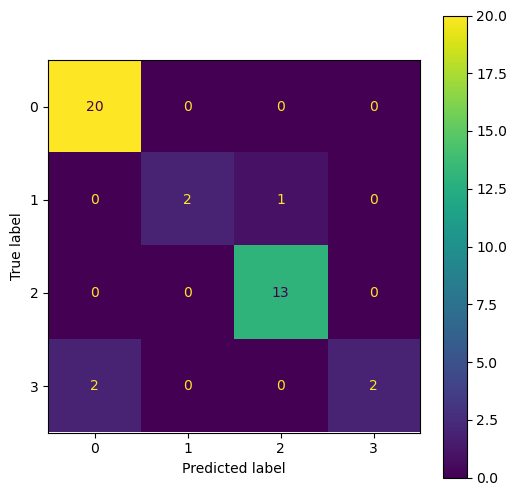

In [126]:
fig, ax = plt.subplots()
#fig, ax = plt.plot(1, 2)
fig.set_size_inches(6, 6)
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax)


In [132]:
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)

total_fp = fp.sum()
total_fn = fn.sum()

print(f"Total False Positives: {total_fp}")
print(f"Total False Negatives: {total_fn}")

Total False Positives: 3
Total False Negatives: 3
